In [4]:
!chmod 0400 ../root/.ssh/id_rsa

In [5]:
!git clone git@github.com:thriftypenguin/litter-imagery-brand-recognition.git
%cd litter-imagery-brand-recognition

Cloning into 'litter-imagery-brand-recognition'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 295 (delta 1), reused 4 (delta 0), pack-reused 287
Receiving objects: 100% (295/295), 118.63 MiB | 23.36 MiB/s, done.
Resolving deltas: 100% (142/142), done.
Updating files: 100% (91/91), done.
/content/litter-imagery-brand-recognition


In [6]:
!git clone https://huggingface.co/spaces/nathanjc/Logo_detection_YoloV7
!pip install -r Logo_detection_YoloV7/requirements.txt

Cloning into 'Logo_detection_YoloV7'...
remote: Enumerating objects: 95, done.
remote: Total 95 (delta 0), reused 0 (delta 0), pack-reused 95 (from 1)
Unpacking objects: 100% (95/95), 15.16 KiB | 352.00 KiB/s, done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 92.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 20.6 MB/s eta 0:00:00
  Using ca

It will ask to restart the kernel at this time. So reset the directory with `cd` here

In [1]:
%cd litter-imagery-brand-recognition
!git clone https://github.com/WongKinYiu/yolov7.git
!pip install -r yolov7/requirements.txt

/content/litter-imagery-brand-recognition
Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Total 1197 (delta 0), reused 0 (delta 0), pack-reused 1197
Receiving objects: 100% (1197/1197), 74.23 MiB | 6.88 MiB/s, done.
Resolving deltas: 100% (519/519), done.


In [12]:
import os
import sys
import argparse
import time
from pathlib import Path
import pandas as pd

import gradio as gr
import cv2
from PIL import Image
import torch
import torch.backends.cudnn as cudnn
from numpy import random
import numpy as np
from google.colab.patches import cv2_imshow
from torchvision.transforms.functional import *
from matplotlib import cm

os.system("pip install yolov7-package==0.0.12")

def detect(opt, save_img=False):
#     from models.experimental import attempt_load
#     from utils.datasets import LoadStreams, LoadImages
#     from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
#         scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
    from yolov7.utils.plots import plot_one_box
#     from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

    from yolov7_package import Yolov7Detector
    from yolov7_package.models.experimental import attempt_load
    from yolov7_package.utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
        scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
    from yolov7_package.utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel
    from yolov7_package.utils.datasets import LoadStreams, LoadImages

    bbox = {}
    source, weights, view_img, save_txt, imgsz, trace = opt.source, opt.weights, opt.view_img, opt.save_txt, opt.img_size, not opt.no_trace
    save_img = not opt.nosave and not source.endswith('.txt')  # save inference images
    webcam = source.isnumeric() or source.endswith('.txt') or source.lower().startswith(
        ('rtsp://', 'rtmp://', 'http://', 'https://'))

    # Directories
    save_dir = Path(increment_path(Path(opt.project) / opt.name, exist_ok=opt.exist_ok))  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Initialize
    set_logging()
    device = select_device(opt.device)
    half = device.type != 'cpu'  # half precision only supported on CUDA

    # Load model
    det = Yolov7Detector(weights=weights, traced=False)
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size

    if trace:
        model = TracedModel(model, device, opt.img_size)

    if half:
        model.half()  # to FP16

    # Second-stage classifier
    classify = False
    if classify:
        modelc = load_classifier(name='resnet101', n=2)  # initialize
        modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model']).to(device).eval()

    # Set Dataloader
    vid_path, vid_writer = None, None
    if webcam:
        view_img = check_imshow()
        cudnn.benchmark = True  # set True to speed up constant image size inference
        dataset = LoadStreams(source, img_size=imgsz, stride=stride)
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride)

    # Get names and colors
    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]

    # Run inference
    if device.type != 'cpu':
        model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
    old_img_w = old_img_h = imgsz
    old_img_b = 1

    t0 = time.time()
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Warmup
        if device.type != 'cpu' and (old_img_b != img.shape[0] or old_img_h != img.shape[2] or old_img_w != img.shape[3]):
            old_img_b = img.shape[0]
            old_img_h = img.shape[2]
            old_img_w = img.shape[3]
            for i in range(3):
                model(img, augment=opt.augment)[0]

        # Inference
        t1 = time_synchronized()
        with torch.no_grad():   # Calculating gradients would cause a GPU memory leak
            pred = model(img, augment=opt.augment)[0]
        t2 = time_synchronized()

        # Apply NMS
        pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
        t3 = time_synchronized()

        # Apply Classifier
        if classify:
            pred = apply_classifier(pred, modelc, img, im0s)

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            if webcam:  # batch_size >= 1
                p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
            else:
                p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name)  # img.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
#                 print(f"BOXES ---->>>> {det[:, :4]}")
                bbox[f"{txt_path.split('/')[4]}"]=(det[:, :4]).numpy()

               # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                i = 0
                for *xyxy, conf, cls in reversed(det):

                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) if opt.save_conf else (cls, *xywh)  # label format
                        with open(txt_path + '.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img or view_img:  # Add bbox to image
                        label = f'{names[int(cls)]} {conf:.2f}'

                        xyxy = [int(coord.item()) for coord in xyxy]

                        # Ensure im0 is in the correct format for PIL
                        if isinstance(im0, torch.Tensor):
                            im0 = im0.numpy()
                        im0 = np.uint8(im0 * 255) if im0.max() <= 1 else np.uint8(im0)

                        # Crop the image using the bounding box coordinates with OpenCV
                        x1, y1, x2, y2 = xyxy
                        cropped_image_cv = im0[y1:y2, x1:x2]

                        # Display the cropped image
                        #cv2_imshow(cropped_image_cv)

                        save_path_indiv_img = str(save_dir)+"/"+'img'+str(i)+".jpeg"
                        #print("label", label, save_path_indiv_img)
                        cv2.imwrite(save_path_indiv_img, cropped_image_cv)


                        plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=1)

                        i += 1

            # Print time (inference + NMS)
            print(f'{s}Done. ({(1E3 * (t2 - t1)):.1f}ms) Inference, ({(1E3 * (t3 - t2)):.1f}ms) NMS')

            # Stream results
            # if view_img:
            #     cv2.imshow(str(p), im0)
            #     cv2.waitKey(1)  # 1 millisecond

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'image':

                    # Image.fromarray(im0).show()
                    #cv2.imwrite(save_path, im0)
                    print(f" The image with the result is saved in: {save_path}")
                # else:  # 'video' or 'stream'
                #     if vid_path != save_path:  # new video
                #         vid_path = save_path
                #         if isinstance(vid_writer, cv2.VideoWriter):
                #             vid_writer.release()  # release previous video writer
                #         if vid_cap:  # video
                #             fps = vid_cap.get(cv2.CAP_PROP_FPS)
                #             w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                #             h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                #         else:  # stream
                #             fps, w, h = 30, im0.shape[1], im0.shape[0]
                #             save_path += '.mp4'
                #         vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                #     vid_writer.write(im0)

    if save_txt or save_img:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        #print(f"Results saved to {save_dir}{s}")

    print(f'Done. ({time.time() - t0:.3f}s)')
    return bbox,save_path


class options:
    def __init__(self, weights, source, img_size=640, conf_thres=0.1, iou_thres=0.45, device='',
                 view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None,
                 agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp',
                 exist_ok=False, no_trace=False):
        self.weights=weights
        self.source=source
        self.img_size=img_size
        self.conf_thres=conf_thres
        self.iou_thres=iou_thres
        self.device=device
        self.view_img=view_img
        self.save_txt=save_txt
        self.save_conf=save_conf
        self.nosave=nosave
        self.classes=classes
        self.agnostic_nms=agnostic_nms
        self.augment=augment
        self.update=update
        self.project=project
        self.name=name
        self.exist_ok=exist_ok
        self.no_trace=no_trace


def get_output(input_image, source):
    ### Numpy -> PIL
    input_image = Image.fromarray(np.array(input_image).astype(np.uint8)).convert('RGB')
    #input_image.save(f"input/image.jpg")
    print(source)#source = f"input/"
    opt = options(weights='best.pt',source=source)
    bbox = None
    with torch.no_grad():
        bbox,output_path = detect(opt)
    if os.path.exists(output_path):
        return Image.open(output_path)
    else:
        return input_image


run.py is a batch script to edit files from yolov7.
When I did pip install yolov7, there was no yolov7/utils. For example, running the following command: !ls /usr/local/lib/python3.10/dist-packages/yolov7/ did not produce the expected directories. I think there was something wrong with the pip install. The commands I used the yielded wrong outputs are as follows. Run run.py to edit the files to be able to run the code

* !pip install yolov7

* !ls /usr/local/lib/python3.10/dist-packages/yolov7/

In [13]:
!python preprocessing/run.py

Running preprocessing/rewrite_experimental.py...
preprocessing/rewrite_experimental.py ran successfully.
Running preprocessing/rewrite_yolov7_utils_general.py...
preprocessing/rewrite_yolov7_utils_general.py ran successfully.
Running preprocessing/rewrite_yolov7_utils_plots.py...
preprocessing/rewrite_yolov7_utils_plots.py ran successfully.


This will get the bounding boxes for all images in the given path

In [14]:
#from os import listdir
#from os.path import isfile, join

brands = ['gatorade', 'polandspring']
for eachbrand in brands:
  pth = 'input/'+eachbrand
  #images = (os.listdir(pth))
  images = [img for img in os.listdir(pth) if img.lower().endswith(('.jpeg', '.jpg'))]
  print(images)
  for each_img in images:
    source = (pth+"/"+each_img)
    print("SOURCE", source)
    im = Image.open(pth+"/"+each_img)

    get_output(im, source)




['bpP4epOojFVLPdRxoJmYxBL2NBnny7EohJZkyoBV.jpeg', 'nOeMMbjEF2YFJIEBk8p37Qq92nDVO62DJYgc12yg.jpeg', 'y2jK1RGFvwNxzrodB57EhgEUt3cAk6cI5dCI5uQF.jpeg', 'UzTbfVMkTHjabspVjVTaUCXz2Z0hA9eWm9iEoniq.jpg']
SOURCE input/gatorade/bpP4epOojFVLPdRxoJmYxBL2NBnny7EohJZkyoBV.jpeg
input/gatorade/bpP4epOojFVLPdRxoJmYxBL2NBnny7EohJZkyoBV.jpeg
Fusing layers... 
IDetect.fuse
Fusing layers... 
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

4 logos, Done. (1744.5ms) Inference, (2.5ms) NMS
 The image with the result is saved in: runs/detect/exp/bpP4epOojFVLPdRxoJmYxBL2NBnny7EohJZkyoBV.jpeg
Done. (2.058s)
SOURCE input/gatorade/nOeMMbjEF2YFJIEBk8p37Qq92nDVO62DJYgc12yg.jpeg
input/gatorade/nOeMMbjEF2YFJIEBk8p37Qq92nDVO62DJYgc12yg.jpeg
Fusing layers... 
IDetect.fuse
Fusing layers... 
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

6 logos, Done. (5062.8ms) Inference, (0.9ms) NMS
 The image with the result is saved i

You need to clean up runs/detect after running the bounding box code because there will be false positives

In [15]:
import torch
import torch.nn.functional as F
from PIL import Image
from transformers import BeitFeatureExtractor, BeitModel
from tqdm import tqdm
import os


def load_image(image_path):
    return Image.open(image_path).convert("RGB")

def generate_beit_embeddings(image_paths, processor, model):
    '''
    This function will generate BEiT Image Embeddings of the logo dataset.
    Output is (n, 768) where n represents the number of images in the logo dataset.

    image_paths: directory of all images
    processor: image processor in the form of BeitFeatureExtractor.from_pretrained('microsoft/beit-base-patch16-224')
    model: a model in the form of BeitModel.from_pretrained('microsoft/beit-base-patch16-224')
    '''
    embeddings = {}

    for image_path in tqdm(image_paths):
        image = load_image(image_path)

        # Preprocess the image
        inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_states = outputs.last_hidden_state

            # Apply mean pooling
            pooled_embedding = torch.mean(last_hidden_states, dim=1)
            embeddings[image_path] = pooled_embedding #embeddings.append(pooled_embedding)

    return embeddings#torch.cat(embeddings, dim=0)


def calculate_cosine_similarity_matrix(X, Y):
    '''
    This function calculates cosine similarity between X and Y inputs.
    '''
    # Normalize the embeddings
    X_normalized = F.normalize(X, p=2, dim=1)
    Y_normalized = F.normalize(Y, p=2, dim=1)

    # Calculate cosine similarity
    cosine_similarity_matrix = torch.mm(X_normalized, Y_normalized.t())
    return cosine_similarity_matrix


def calculate_cosine_similarity_matrix2(X, Y):
  from numpy.linalg import norm
  all_similarities = []


  for i, x_embedding in enumerate(X):
      similarities = []
      for y_embedding in Y:
        cosine = ((x_embedding * y_embedding).sum(dim=-1) / (torch.norm(x_embedding, dim=-1) * torch.norm(y_embedding, dim=-1))).mean().item()

        similarities.append(cosine)
      all_similarities.append(similarities)
  return (all_similarities)




feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-patch16-224')
model = BeitModel.from_pretrained('microsoft/beit-base-patch16-224')

'''
# Example usage with actual image paths
logo_image_paths = ["runs/detect/exp6/img0.jpeg"]  # Replace with actual paths
cutout_image_paths = ["Logo_dataset_RAW/gatorade/2cb6fade-59f2-4110-8538-ab76b8831f54.jpg"]  # Replace with actual paths

# Generate embeddings for logo dataset
logo_embeddings1 = generate_beit_embeddings(logo_image_paths, feature_extractor, model)

# Generate embeddings for cutout images
logo_embeddings2 = generate_beit_embeddings(cutout_image_paths, feature_extractor, model)

# Compute cosine similarity matrix
similarity_matrix = calculate_cosine_similarity_matrix(logo_embeddings1, logo_embeddings2)

# Print similarity matrix
print(similarity_matrix)'''

/usr/local/lib/python3.10/dist-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(


'\n# Example usage with actual image paths\nlogo_image_paths = ["runs/detect/exp6/img0.jpeg"]  # Replace with actual paths\ncutout_image_paths = ["Logo_dataset_RAW/gatorade/2cb6fade-59f2-4110-8538-ab76b8831f54.jpg"]  # Replace with actual paths\n\n# Generate embeddings for logo dataset\nlogo_embeddings1 = generate_beit_embeddings(logo_image_paths, feature_extractor, model)\n\n# Generate embeddings for cutout images\nlogo_embeddings2 = generate_beit_embeddings(cutout_image_paths, feature_extractor, model)\n\n# Compute cosine similarity matrix\nsimilarity_matrix = calculate_cosine_similarity_matrix(logo_embeddings1, logo_embeddings2)\n\n# Print similarity matrix\nprint(similarity_matrix)'

Create BEiT Image Embeddings of the Logo dataset, let’s call this X which will be a dataset. The length will be the number of images. For each item, it will have the shape `torch.Size([1, 768])`. The key is the path where the image was retrieved from



In [18]:
dataset_dir = 'Logo_dataset_RAW/'
labels = ("gatorade", "polandspring")
image_paths = [os.path.join(dataset_dir, fname, each_image) for fname in os.listdir(dataset_dir) for each_image in os.listdir(dataset_dir+"/"+fname) if fname.endswith(labels) if each_image.endswith(('.png', '.jpg', '.jpeg'))]
print(image_paths)
X = generate_beit_embeddings(image_paths, feature_extractor, model)

len(X)

['Logo_dataset_RAW/gatorade/img01.jpeg', 'Logo_dataset_RAW/gatorade/img03.jpeg', 'Logo_dataset_RAW/gatorade/img5.jpeg', 'Logo_dataset_RAW/gatorade/img0.jpeg', 'Logo_dataset_RAW/polandspring/img2.jpeg', 'Logo_dataset_RAW/polandspring/img1.jpeg', 'Logo_dataset_RAW/polandspring/img02.jpeg']


100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


7

I passed the image in question through the Logo detection model and got the cutout logos, created Image Embeddings of these cutout images also, calling this vector Y (shape will be (m,768) where m is the number of images/bboxes created by the Logo detection model on that image)


The following cell gets the bounding box for one input image

input/gatorade.jpeg
Fusing layers... 
IDetect.fuse
Fusing layers... 
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

4 logos, Done. (2859.8ms) Inference, (0.8ms) NMS
 The image with the result is saved in: runs/detect/exp9/gatorade.jpeg
Done. (2.905s)


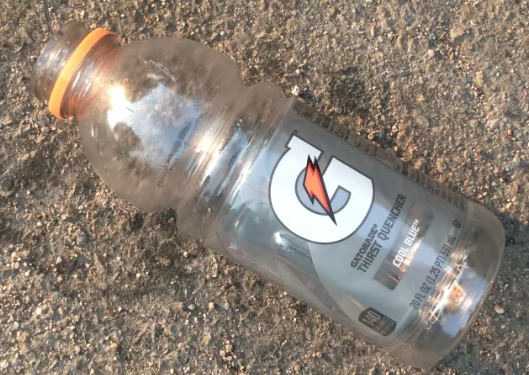

In [22]:
im = Image.open('input/gatorade.jpeg')
get_output(im, "input/gatorade.jpeg")



In [23]:
dataset_dir = 'runs/detect/exp9'
image_paths = [os.path.join(dataset_dir, fname) for fname in os.listdir(dataset_dir) if fname.endswith(('.jpeg', 'jpg'))]
print(image_paths)

input_img = generate_beit_embeddings(image_paths, feature_extractor, model)

len(input_img)

['runs/detect/exp9/img0.jpeg']


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


1

In [25]:
def get_similar_images(images_to_compare, input_image, threshold_value = 0.60):
  high_similarities = []
  for each_x in images_to_compare.keys():
    for each_input_img in input_image.keys():

      # calculate the similarity
      calculated_similarity = calculate_cosine_similarity_matrix(images_to_compare[each_x], input_image[each_input_img])

      # print all results
      print(each_x,each_input_img, calculated_similarity)

      # if the similarity value for the pair of images is greater than or equal
      # to threshold value, add it to high_similarity
      if calculated_similarity >= threshold_value:
        high_similarities.append(each_x)
  return high_similarities

similar_images = get_similar_images(X, input_img)

print("---------- OUTPUT ----------")
print(similar_images)

Logo_dataset_RAW/gatorade/img01.jpeg runs/detect/exp9/img0.jpeg tensor([[0.51046]])
Logo_dataset_RAW/gatorade/img03.jpeg runs/detect/exp9/img0.jpeg tensor([[0.48042]])
Logo_dataset_RAW/gatorade/img5.jpeg runs/detect/exp9/img0.jpeg tensor([[0.38537]])
Logo_dataset_RAW/gatorade/img0.jpeg runs/detect/exp9/img0.jpeg tensor([[0.67227]])
Logo_dataset_RAW/polandspring/img2.jpeg runs/detect/exp9/img0.jpeg tensor([[0.06172]])
Logo_dataset_RAW/polandspring/img1.jpeg runs/detect/exp9/img0.jpeg tensor([[0.07434]])
Logo_dataset_RAW/polandspring/img02.jpeg runs/detect/exp9/img0.jpeg tensor([[0.13741]])
________
['Logo_dataset_RAW/gatorade/img0.jpeg']


Next I fit a SVM with vector X (shape will be (n,768)) and a encoded version vector Y (shape will be (m,768)) using sklearn’s LabelEncoder using svm.fit(X,Y)

In [26]:
!pip install git+https://github.com/openai/CLIP.git
!pip install open_clip_torch
!pip install sentence_transformers


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-y039x5x9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-y039x5x9
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=ce8700dea1379de3354d7e6e52271e9a53b53008ea95247c7141d16d6ef723ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-mni9bdyd/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.0 MB/s eta 0:00:00


#CLIP-Based pre-trained model

CLIP (Contrastive Language-Image Pre-Training) from the openAI is an impressive multimodal zero-shot image classifier that achieves impressive results in a wide range of domains with no fine-tuning. It applies the recent advancements in large-scale transformers like GPT-3 to the vision arena.

source: https://medium.com/scrapehero/exploring-image-similarity-approaches-in-python-b8ca0a3ed5a3

In [51]:

import torch
import open_clip
import cv2
from sentence_transformers import util
from PIL import Image
# image processing model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16-plus-240', pretrained="laion400m_e32")
model.to(device)
def imageEncoder(img):
    img1 = Image.fromarray(img).convert('RGB')
    img1 = preprocess(img1).unsqueeze(0).to(device)
    img1 = model.encode_image(img1)
    return img1
def generateScore(image1, image2):
    test_img = cv2.imread(str(image1), cv2.IMREAD_UNCHANGED)

    data_img = cv2.imread(str(image2), cv2.IMREAD_UNCHANGED)
    if test_img is None:
        raise ValueError(f"Error loading image1: {image1}")
    if data_img is None:
        raise ValueError(f"Error loading image2: {image2}")
    img1 = imageEncoder(test_img)
    img2 = imageEncoder(data_img)
    euclidean_distance = torch.dist(img1, img2).item()
    #cos_scores = util.pytorch_cos_sim(img1, img2)
    #score = round(float(euclidean_distance[0][0])*100, 2)
    return euclidean_distance#score
#image1 = 'Logo_dataset_RAW/gatorade/img0.jpeg'
#image2 = 'Logo_dataset_RAW/gatorade/img5.jpeg'
print(f"similarity Score: ", round(generateScore(image1, image2), 2))


similarity Score:  10.14


In [52]:
def get_similar_images_euclid(images_to_compare, input_image):
  high_similarities = []
  for each_x in images_to_compare.keys():
    for each_input_img in input_image.keys():
      print((each_x))
      # calculate the similarity
      calculated_similarity = generateScore(each_x, each_input_img)

      # print all results
      print(each_x,each_input_img, calculated_similarity)

      # if the similarity value for the pair of images is greater than or equal
      # to threshold value, add it to high_similarity

        #high_similarities.append(each_x)
  #return high_similarities

similar_images = get_similar_images_euclid(X, input_img)

Logo_dataset_RAW/gatorade/img01.jpeg
Logo_dataset_RAW/gatorade/img01.jpeg runs/detect/exp9/img0.jpeg 11.501925468444824
Logo_dataset_RAW/gatorade/img03.jpeg
Logo_dataset_RAW/gatorade/img03.jpeg runs/detect/exp9/img0.jpeg 9.626446723937988
Logo_dataset_RAW/gatorade/img5.jpeg
Logo_dataset_RAW/gatorade/img5.jpeg runs/detect/exp9/img0.jpeg 10.971955299377441
Logo_dataset_RAW/gatorade/img0.jpeg
Logo_dataset_RAW/gatorade/img0.jpeg runs/detect/exp9/img0.jpeg 9.167987823486328
Logo_dataset_RAW/polandspring/img2.jpeg
Logo_dataset_RAW/polandspring/img2.jpeg runs/detect/exp9/img0.jpeg 16.509782791137695
Logo_dataset_RAW/polandspring/img1.jpeg
Logo_dataset_RAW/polandspring/img1.jpeg runs/detect/exp9/img0.jpeg 17.136045455932617
Logo_dataset_RAW/polandspring/img02.jpeg
Logo_dataset_RAW/polandspring/img02.jpeg runs/detect/exp9/img0.jpeg 14.954041481018066
